# Detección de tumores cerebrales en resonancias magnéticas

In [ ]:
# Correr esta celda solamente en colab
!git clone https://github.com/ColossalCoin/TDA-Delfin.git
!pip install -U giotto-tda
%cd TDA-Delfin

## Análisis topológico de las resonancias originales

Comenzaremos el análisis tomando las dos primeras resonancias de de cada clase, es decir, una resonancia con tumor presente y una sin tumor. Posteriormente desarrollaremos un pipeline en el que podamos aplicar un análisis similar a todos las imágenes del conjunto de datos y entrenar un modelo de machine learning que aproveche dicho análisis.

El método central utilizado en este análisis será el cálculo de homología persistente mediante complejos cúbicos.

In [187]:
from data.image_converter import get_images

images_yes, images_no = get_images(image_size=(224, 224))

im_yes = images_yes[0]
im_no = images_no[0]

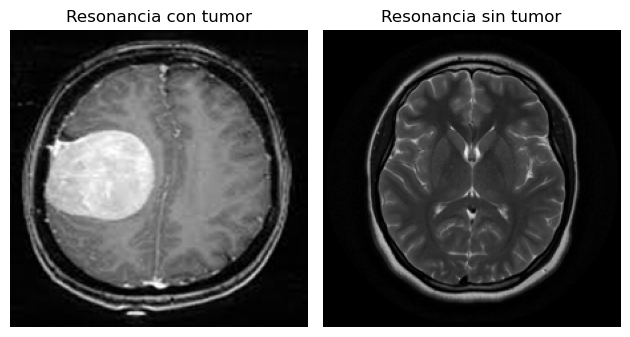

In [188]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1, 2, 1)
plt.title('Resonancia con tumor')
plt.imshow(im_yes, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resonancia sin tumor')
plt.imshow(im_no, cmap='gray')
plt.axis('off')

plt.tight_layout()

### Persistencia cúbica de la imagen original

Dado que las resonancias magnéticas (MRI) son imágenes en escala de grises, el primer paso natural en la búsqueda de características topológicas es el de asociar un complejo cúbico $K$ a cada imagen $\mathcal I$ vista como función
$$
\mathcal I:I\subset\mathbb Z^2\to\mathbb R,
$$
donde cada $v\in I$ representa un píxel y el valor $\mathcal I(v)\in\mathbb R$ representa la intensidad o valor en la escala de grises. La construcción de $K$ se obtiene entonces considerando la filtración natural $\{K_i\}_{i\in\text{Im}(I)}$ dada por
$$
K_i:=\{v\in I:\mathcal I(v)\leq i\}
$$
donde $K_i$ es llamado el *$i$-ésmo conjunto de subnivel* de $K$. [[1]](https://arxiv.org/pdf/1910.08345)

In [190]:
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler

# Redimencionamos las imagenes de acuerdo al input de los métodos fit_transform
im_yes = images_yes[0][None, :, :]
im_no = images_no[0][None, :, :]

cubical_persistence = CubicalPersistence(n_jobs=-1)
scaler = Scaler(n_jobs=-1)

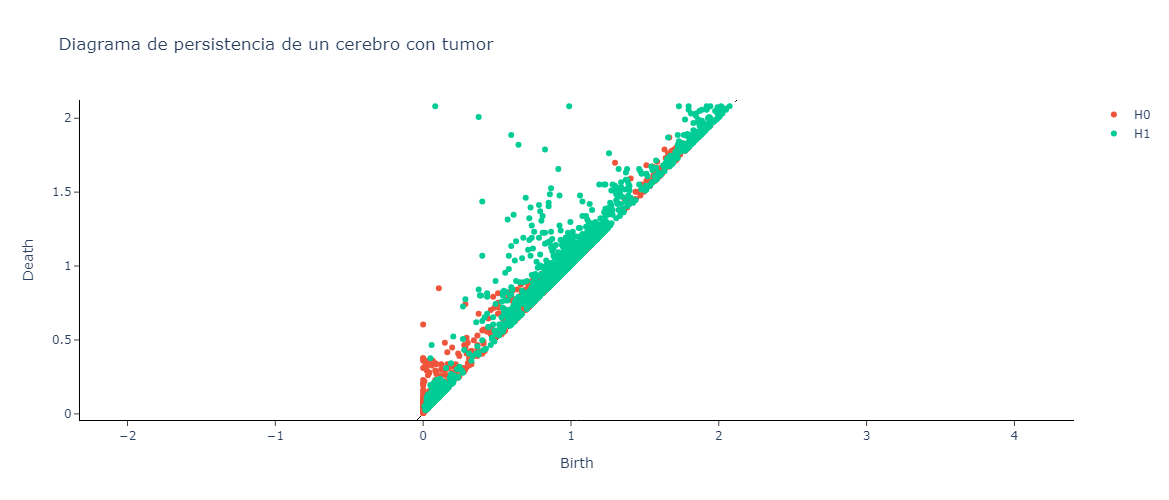

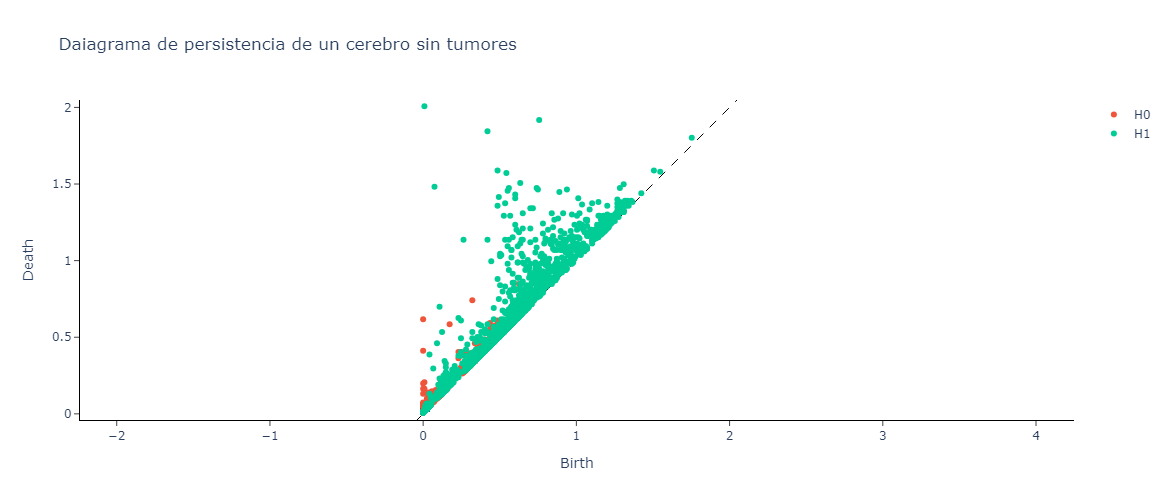

In [191]:
im_yes_cubical = cubical_persistence.fit_transform(im_yes)
im_no_cubical = cubical_persistence.fit_transform(im_no)

im_yes_scaled = scaler.fit_transform(im_yes_cubical)
im_no_scaled = scaler.fit_transform(im_no_cubical)

im_yes_scaled_plot = scaler.plot(im_yes_scaled, 
                                         plotly_params={'layout':{'title':'Diagrama de persistencia de un cerebro con tumor'}})
im_no_scaled_plot = scaler.plot(im_no_scaled, 
                                       plotly_params={'layout':{'title':'Daiagrama de persistencia de un cerebro sin tumores'}})

im_yes_scaled_plot.show()
im_no_scaled_plot.show()

En los diagramas de persistencia anteriores podemos observar diferencias en el número de puntos pertenecientes tanto a $H_0$ como a $H_1$, sin embargo, es difícil visualizar más diferencias entre estos diagramas, en parte por la gran cantidad de puntos irrelevantes (cercanos a la diagonal) presentes en ambos diagramas. De esta fomra, resulta conveniente *filtrar* el diagrama para deshacernos de los puntos más cercanos a la diagonal.

In [193]:
from gtda.diagrams import Filtering

filtering = Filtering(homology_dimensions=[0, 1], epsilon=0.1)

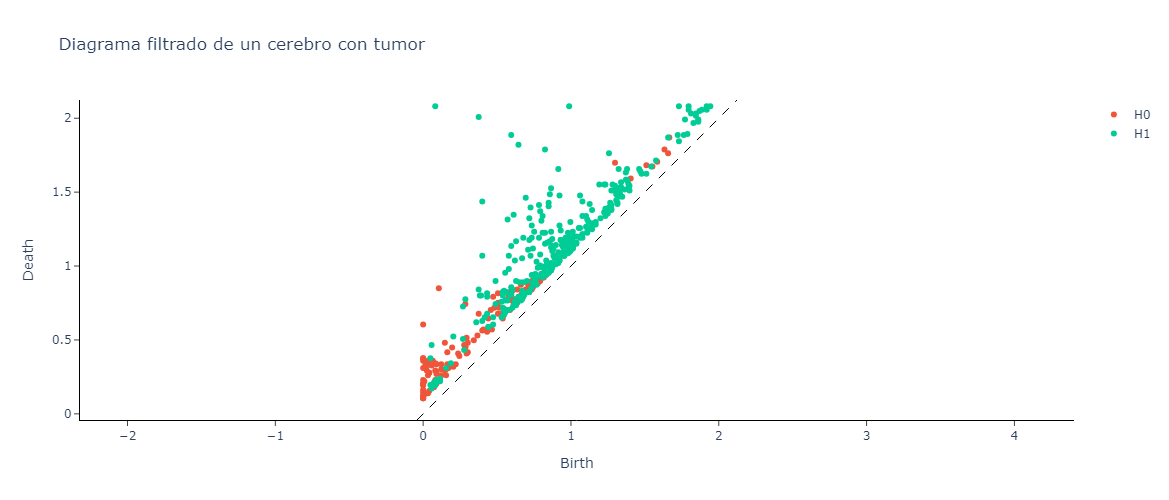

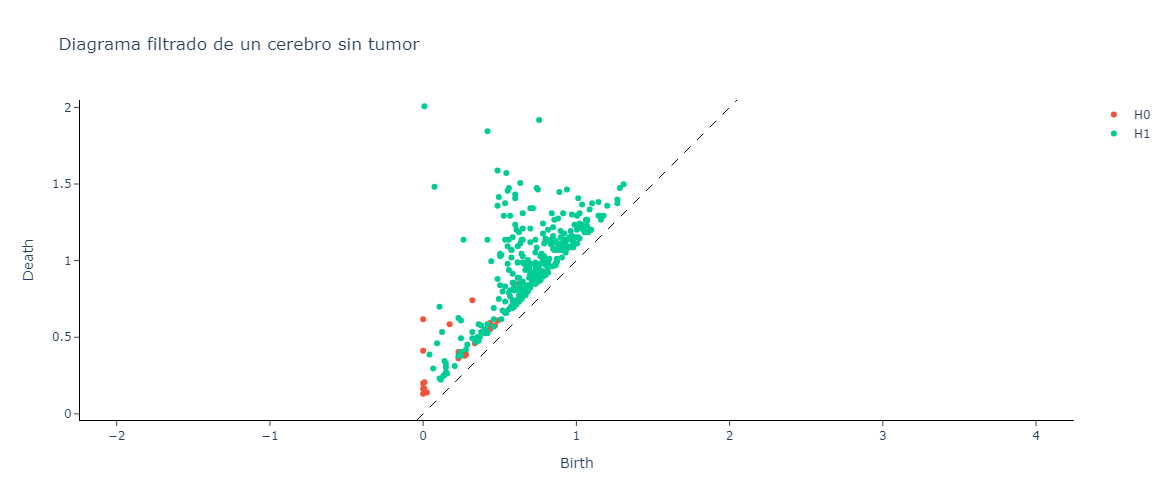

In [194]:
im_yes_filtered = filtering.fit_transform(im_yes_scaled)
im_no_filtered = filtering.fit_transform(im_no_scaled)

im_yes_filtered_plot = filtering.plot(im_yes_filtered, plotly_params={'layout':{'title':'Diagrama filtrado de un cerebro con tumor'}})
im_no_filtered_plot = filtering.plot(im_no_filtered,  plotly_params={'layout':{'title':'Diagrama filtrado de un cerebro sin tumor'}})

im_yes_filtered_plot.show()
im_no_filtered_plot.show()

Aún así, existen mejores formas de visualizar la información contenida en los diagramas de persistencia, las cuales abordaremos a continuación.

### Paisaje de persistencia
Una de las representaciones es el *paisaje de persistencia*, el cual se construye partir de un diagrama de persistencia $\mathcal D$ donde los puntos $(b,d)\in\mathcal D$ son tranformados de tal forma que
$$
(b,d)\mapsto\left(\frac{b+d}{2}, \frac{d-b}{2}\right).
$$
En esta representación se descartan los puntos con persistencia infinita. De esta forma, el *paisaje* se define a partir del conjunto de funciones creadas al rotar el diagrama de persistencia, de tal forma que
$$
\Lambda_p(t)=\begin{cases}
t-b, & t\in\left[b,\frac{b+d}{2}\right] \\
d-t, & t\in\left(\frac{b+d}{2}, d\right] \\
0,   & \text{en cualquier otro caso.}
\end{cases}
$$
Así, el paisaje de persistencia $\Lambda_{\mathcal D}$ se obtiene de superponer las gráficas de las funciones $\Lambda_p(t).$ [[2]](https://www.frontiersin.org/journals/artificial-intelligence/articles/10.3389/frai.2021.667963/full)

<center>
    <img src="Figures/landscape_example.jpg" alt="Ejemplo de un paisaje de persistencia" width=40% height=auto border=2/>
    <figcaption>Figura 1: Ejemplo de un paisaje de persistencia (derecha) a partir de un diagrama de persistencia (izquierda).</figcaption>
</center>

Conviene solo considerar una cantidad pequeña de funciones $\Lambda_p$ para facilitar la interpretación, por lo que solo consideraremos dos *capas*.

In [197]:
from gtda.diagrams import PersistenceLandscape

persistence_landscape = PersistenceLandscape(n_layers=2, n_bins=10, n_jobs=-1)

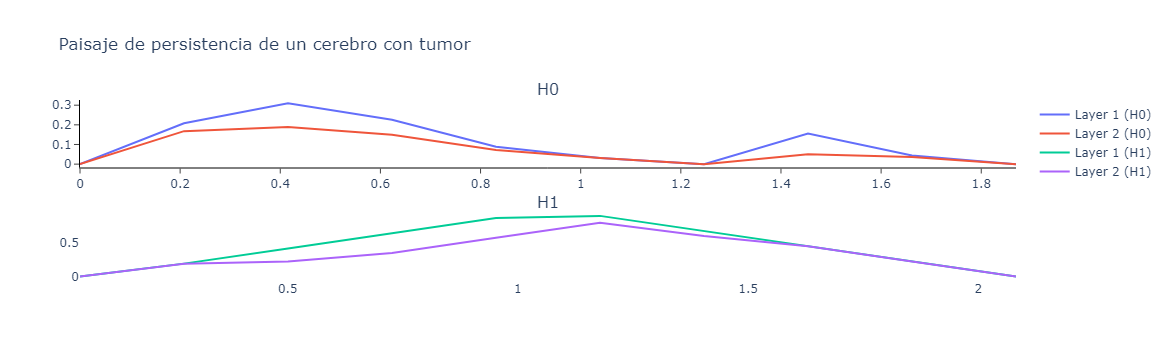

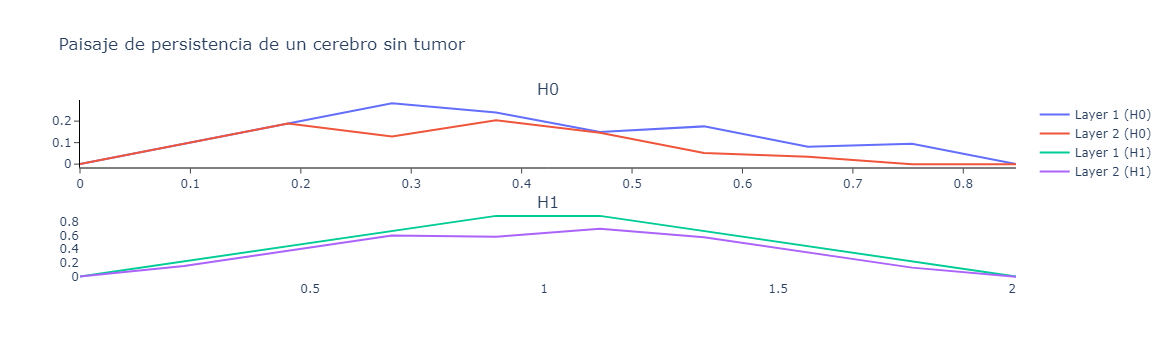

In [198]:
im_yes_landscape_plot = persistence_landscape.fit_transform_plot(im_yes_filtered, 
                                                                 plotly_params={'layout':{'title':'Paisaje de persistencia de un cerebro con tumor'}})
im_no_landscape_plot = persistence_landscape.fit_transform_plot(im_no_filtered, 
                                                                plotly_params={'layout':{'title':'Paisaje de persistencia de un cerebro sin tumor'}})

### Curvas de Betti

Definimos la curva de Betti de dimensión homológica $k$ como
$$
\beta_k(t):=\sum_{(b,d)\in\mathcal D}w(b,d)1_{t\in[b,d]}
$$
donde $w$ es la función de peso definida sobre la diagonal $\Delta$ de $\mathcal D$. Es decir, la curva de Betti es el némero de generadores en un tiempo $t$. [[2]](https://www.frontiersin.org/journals/artificial-intelligence/articles/10.3389/frai.2021.667963/full)

La información sobre la función de peso considerada en la función `BettiCurve` de `giotto-tda` puede ser encontrada en la [documentación oficial](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html#gtda.diagrams.BettiCurve) de `giotto-tda`.

In [200]:
from gtda.diagrams import BettiCurve

betti_curve = BettiCurve(n_bins=10, n_jobs=-1)

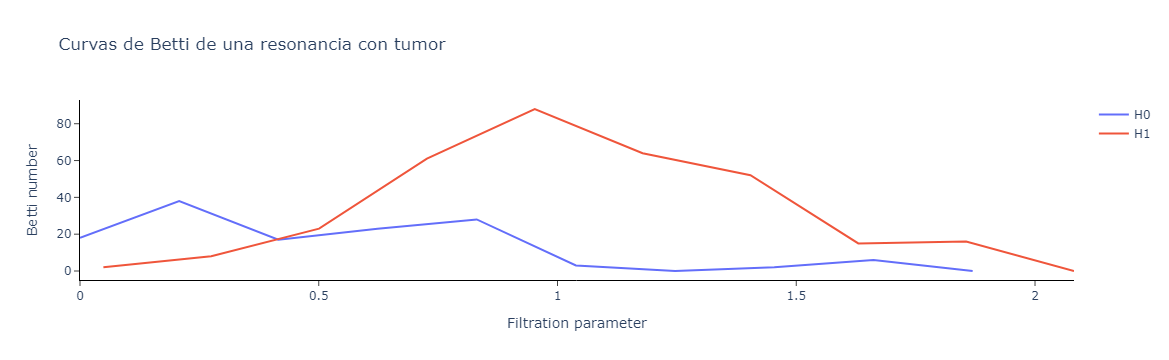

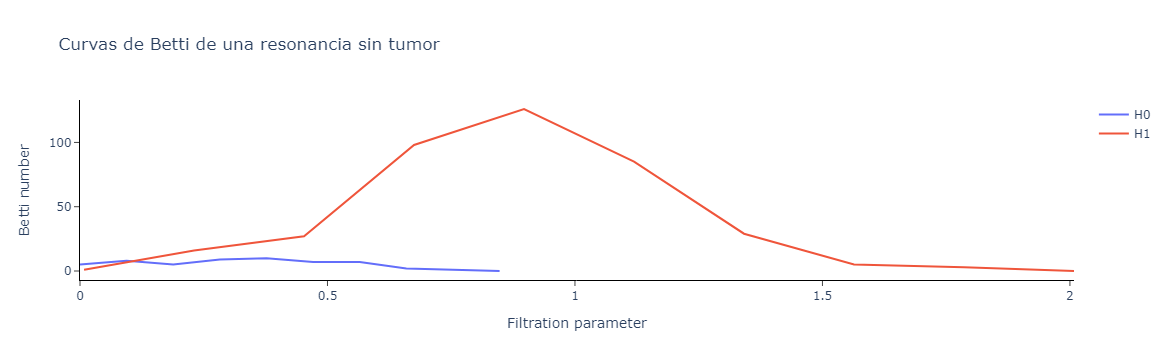

In [201]:
im_yes_betti_plot = betti_curve.fit_transform_plot(im_yes_filtered, plotly_params={'layout':{'title':'Curvas de Betti de una resonancia con tumor'}})
im_no_betti_plot = betti_curve.fit_transform_plot(im_no_filtered,  plotly_params={'layout':{'title':'Curvas de Betti de una resonancia sin tumor'}})

Podemos observar diferencias notables entre las curvas de Betti de ambos diagramas. En el caso de $H_0$, la curva de Betti de la resonancia magnética con tumor presenta dos máximos locales muy marcados, mientras que la de la resonancia de un cerebro sin tumor no presenta máximos marcados. En el caso de $H_1$, si bien las curvas no parecen ser muy distintas salvo por el intervalo [1.5, 2] del parámetro de filtración, las escalas de ambas curvas son distintas.

### Siluetas
Como se mencionó anteriormente, el paisaje de persistencia puede ser interpretado como una función $\Lambda_p$ continua real valuada asociada a cada subdiagrama; una función de resumen. Formalmente, una *función resumen* es un funtor que toma un diagrama de persistencia y devuelve una función continua real valuada. Si el diagrama corresponde a la función de distancia a un conjunto aleatorio, entonces se tiene una distribución de probabilidad en el espacio de funciones resumen inducida por una función de probabilidad en el espacio de muestreo original. [[3]](https://dl.acm.org/doi/10.1145/2582112.2582128)

Dicho lo anterior, es posible obtener diversas formas de resumir un diagrama de persistencia, además de los ya mencionados paisajes de persistencia. Es este apartado utilizaremos *siluetas ponderadas* para resumir los diagramas de persistencia de las resonancias con y sin tumor. Dado un diagrama de persistencia con $m$ puntos fuera de la diagonal, consideramos la media ponderada de las funciones $\Lambda_p$
$$
\phi(t)=\frac{\sum_{j=1}^m w_j\Lambda_j(t)}{\sum_{j=1}^m w_j}.
$$
Para el caso en que $w_i=|d_i-b_i|^p$ nos referimos a $\phi$ como la *silueta ponderada con potencia p*. En la implementación de `Giotto-tda` solo se consideran estas últimas, donde $p$ se especifica mediante el parámetro `power`.

In [204]:
from gtda.diagrams import Silhouette

silhouette = Silhouette(power=0.1, n_bins=100, n_jobs=-1)

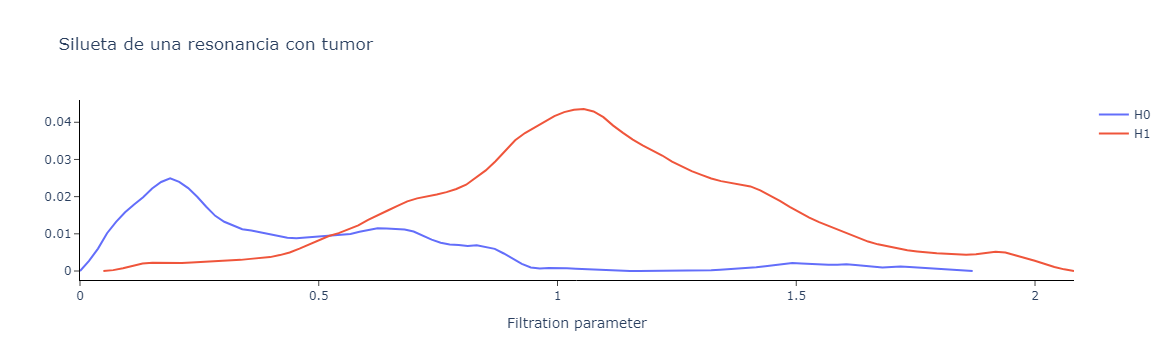

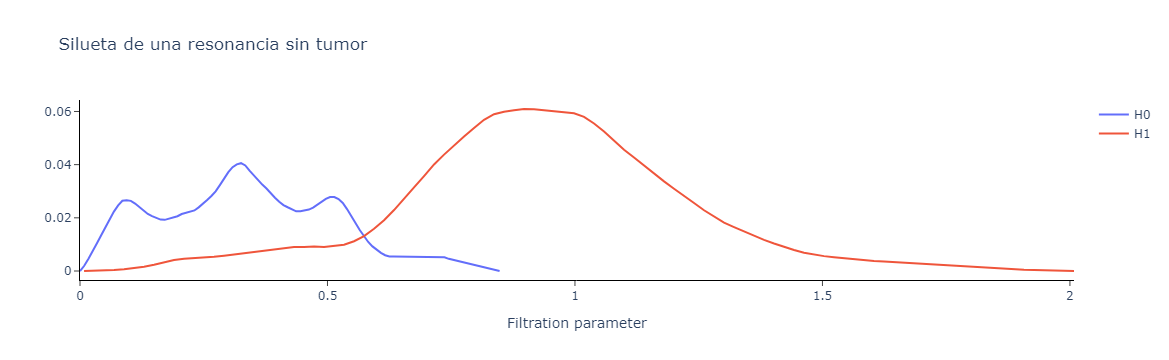

In [205]:
im_yes_silhoutte_plot = silhouette.fit_transform_plot(im_yes_filtered, plotly_params={'layout':{'title':'Silueta de una resonancia con tumor'}})
im_no_slihouette_plot = silhouette.fit_transform_plot(im_no_filtered, plotly_params={'layout':{'title':'Silueta de una resonancia sin tumor'}})

### Núcleo de calor
Como es común en *machine learning*, una de las técnicas de análisis de datos de todo tipo son lo método de núcleo gaussiano. Con base en [[4]](https://ieeexplore.ieee.org/document/7299106/keywords#keywords), `Giotto-tda` implementó una técnica en la que se considera a $\mathcal D$ como una suma de distribuciones delta de Dirac correspondientes a cada subdiagrama (considerando una única dimensión homológica para cada uno) y se aplican convoluciones con el núcleo gaussiano a partir de una malla rectangular uniformemente espaciada y se repite el proceso con las imágenes de los subdiagramas reflejados con respecto a la diagonal. 

En [[4]](https://ieeexplore.ieee.org/document/7299106/keywords#keywords) Se hace énfasis en la elección de un $\sigma$ adecuado, el cual puede ser especifiacado mediante el parámetro `sigma`. Tomaremos $\sigma=0.5$ con la finalidad de resaltar las diferencias entre ambas imágenes. El resultado de aplicar dichas convoluciones pude visualizarse a continuación.

In [207]:
from gtda.diagrams import HeatKernel

heat_kernel = HeatKernel(sigma=0.05, n_bins=100, n_jobs=-1)

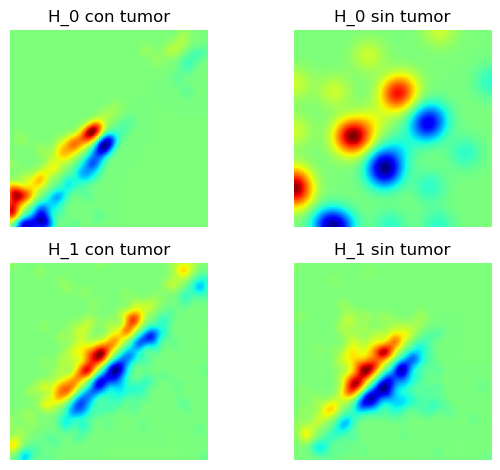

In [208]:
im_yes_heat = heat_kernel.fit_transform(im_yes_filtered)
im_no_heat = heat_kernel.fit_transform(im_no_filtered)

im_yes_heat_plot_0 = heat_kernel.plot(im_yes_heat, homology_dimension_idx=0)
im_yes_heat_plot_1 = heat_kernel.plot(im_yes_heat, homology_dimension_idx=1)
im_no_heat_plot_0 = heat_kernel.plot(im_no_heat, homology_dimension_idx=0)
im_no_heat_plot_1 = heat_kernel.plot(im_no_heat, homology_dimension_idx=1)

plt.figure()

plt.subplot(2, 2, 1)
plt.title('H_0 con tumor')
plt.imshow(im_yes_heat_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('H_0 sin tumor')
plt.imshow(im_no_heat_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('H_1 con tumor')
plt.imshow(im_yes_heat_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('H_1 sin tumor')
plt.imshow(im_no_heat_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.tight_layout()

En este caso, no es sencillo interpretar la información contenida en los diagramas anteriores, pero es importante recalcar que existen diferencias notorias entre los diagramas asociados a la resonancia con tumor y sin tumor, tanto en dimensión homológica 0 como en 1.

### Imagen de persistencia

Al igual que con el núcleo de calor, las imágenes de persistencia surgen de realizar convoluciones con un néclo gaussiano sobre una malla rectangular uniformemente espaciada, esta vez aplicada al diagrama rotado $-\frac{\pi}{4}$ como puede verse en la siguiente figura:

<center>
    <img src="Figures/rotated_pd.png" alt="Diagrama de persistencia rotado" width=30% height=auto border=2/>
    <figcaption>Figura 2: Diagrama de persistencia original (izquierda) y diagrama de persistencia rotado (derecha).</figcaption>
</center>


In [211]:
from gtda.diagrams import PersistenceImage

persistence_image = PersistenceImage(sigma=0.06, n_bins=100, n_jobs=-1)

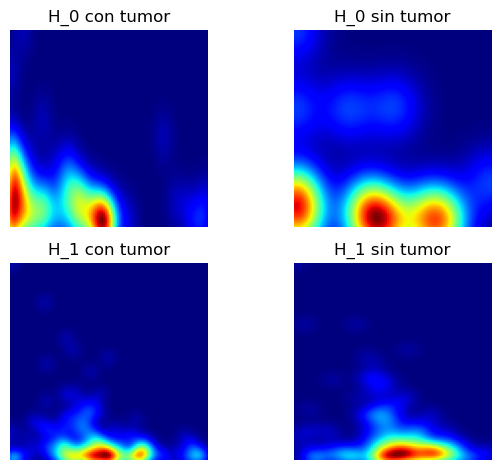

In [220]:
im_yes_image = persistence_image.fit_transform(im_yes_filtered)
im_no_image = persistence_image.fit_transform(im_no_filtered)

im_yes_image_plot_0 = persistence_image.plot(im_yes_image, homology_dimension_idx=0)
im_yes_image_plot_1 = persistence_image.plot(im_yes_image, homology_dimension_idx=1)
im_no_image_plot_0 = persistence_image.plot(im_no_image, homology_dimension_idx=0)
im_no_image_plot_1 = persistence_image.plot(im_no_image, homology_dimension_idx=1)

plt.figure()

plt.subplot(2, 2, 1)
plt.title('H_0 con tumor')
plt.imshow(im_yes_image_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('H_0 sin tumor')
plt.imshow(im_no_image_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('H_1 con tumor')
plt.imshow(im_yes_image_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('H_1 sin tumor')
plt.imshow(im_no_image_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.tight_layout()

## Procesamiento de las resonancias

Si bien podemos continuar el proceso de extracción de características topológicas con los diagramas asociados a las imágenes originales, otra aproximación conveniente binarizar las imágenes originales con la finalidad de eliminar ruido y características no deseadas en las mismas, así como resaltar las características que deseamos obtener.

Para el proceso de binarización es necesario elegir un umbral, es decir, consideraremos la filtración natural de las imágenes en escala de grises fijando $i\in\text{Im}(I)$ para tomar únicamente el conjunto de subnivel $K_i$.

In [ ]:
from gtda.images import Binarizer

im_yes2 = images_yes[1][None, :, :]
im_yes3 = images_yes[2][None, :, :]

binarizer = Binarizer(threshold=5, n_jobs=-1)

In [242]:
im_yes_heat = heat_kernel.fit_transform(im_yes_scaled)
im_no_heat = heat_kernel.fit_transform(im_no_scaled)

### Distintos filtros de densidad con un radio pequeño

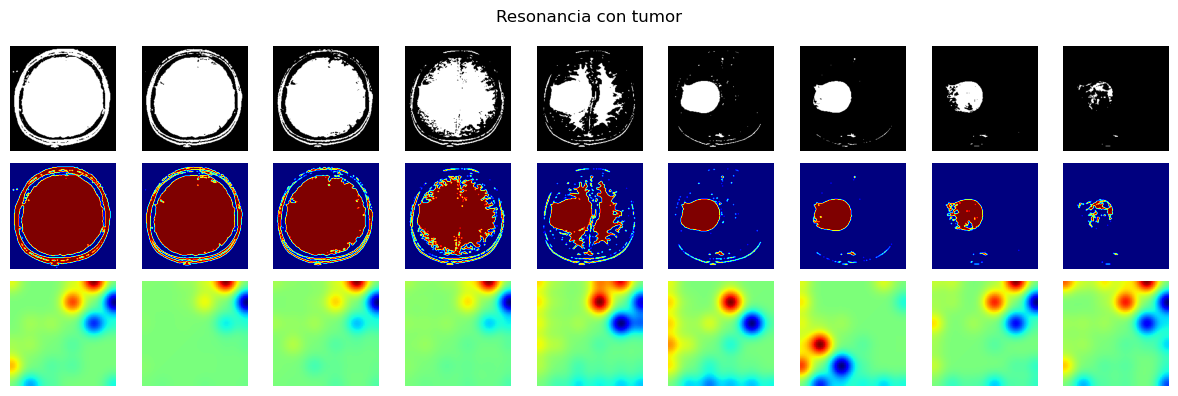

In [17]:
from gtda.images import Binarizer
from gtda.images import DensityFiltration
density_filtration = DensityFiltration(radius=1, metric='euclidean', n_jobs=-1)

plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia con tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_yes_binarized = binarizer.fit_transform(im_yes)
    im_yes_binarized_plot = binarizer.plot(im_yes_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_yes_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_yes_density = density_filtration.fit_transform(im_yes_binarized)
    im_yes_density_plot = density_filtration.plot(im_yes_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_yes_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_yes_cubical = cubical_persistence.fit_transform(im_yes_density)
    im_yes_cubical_scaled = scaler.fit_transform(im_yes_cubical)
    im_yes_cubical_heat = heat_kernel.fit_transform(im_yes_cubical_scaled)
    im_yes_cubical_heat_plot = heat_kernel.plot(im_yes_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_yes_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

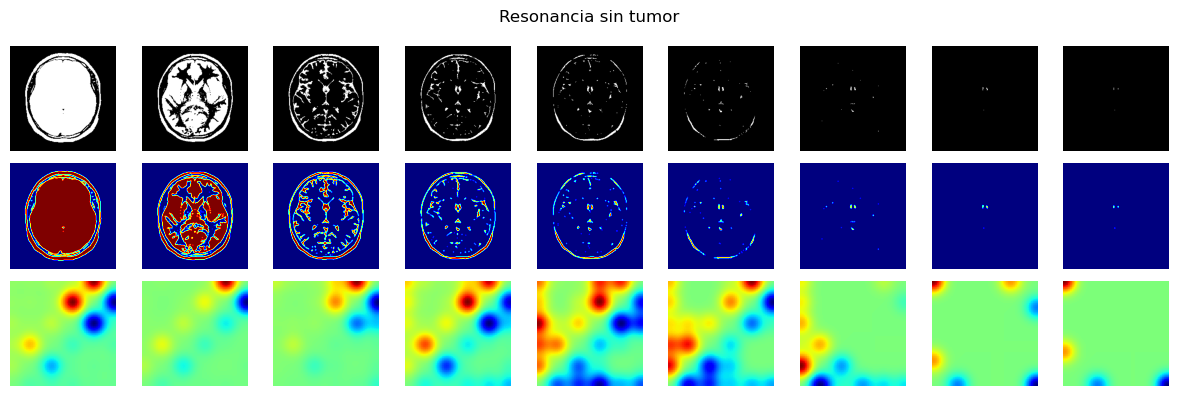

In [18]:
plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia sin tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_no_binarized = binarizer.fit_transform(im_no)
    im_no_binarized_plot = binarizer.plot(im_no_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_no_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_no_density = density_filtration.fit_transform(im_no_binarized)
    im_no_density_plot = density_filtration.plot(im_no_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_no_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_no_cubical = cubical_persistence.fit_transform(im_no_density)
    im_no_cubical_scaled = scaler.fit_transform(im_no_cubical)
    im_no_cubical_heat = heat_kernel.fit_transform(im_no_cubical_scaled)
    im_no_cubical_heat_plot = heat_kernel.plot(im_no_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_no_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

### Distintos filtros de densidad con un radio grande

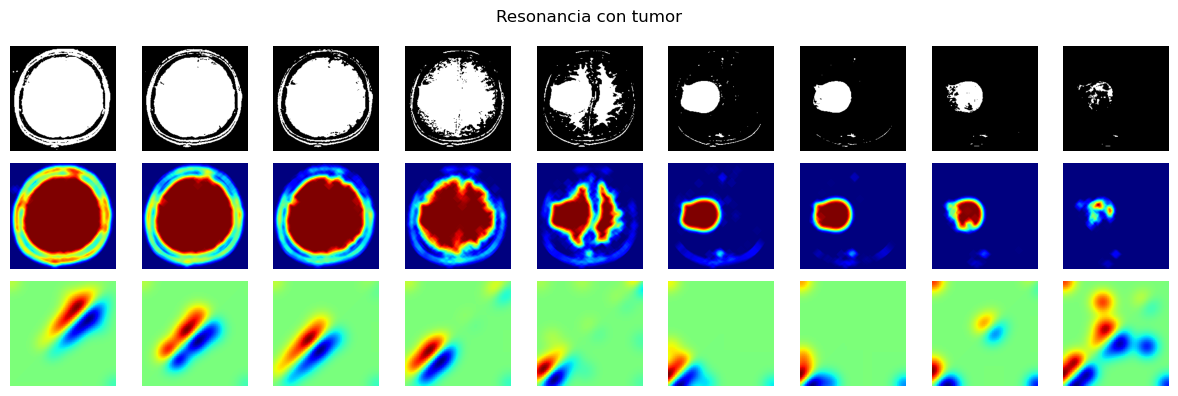

In [25]:
density_filtration = DensityFiltration(radius=10, metric='cityblock', n_jobs=-1)

plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia con tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_yes_binarized = binarizer.fit_transform(im_yes)
    im_yes_binarized_plot = binarizer.plot(im_yes_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_yes_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_yes_density = density_filtration.fit_transform(im_yes_binarized)
    im_yes_density_plot = density_filtration.plot(im_yes_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_yes_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_yes_cubical = cubical_persistence.fit_transform(im_yes_density)
    im_yes_cubical_scaled = scaler.fit_transform(im_yes_cubical)
    im_yes_cubical_heat = heat_kernel.fit_transform(im_yes_cubical_scaled)
    im_yes_cubical_heat_plot = heat_kernel.plot(im_yes_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_yes_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

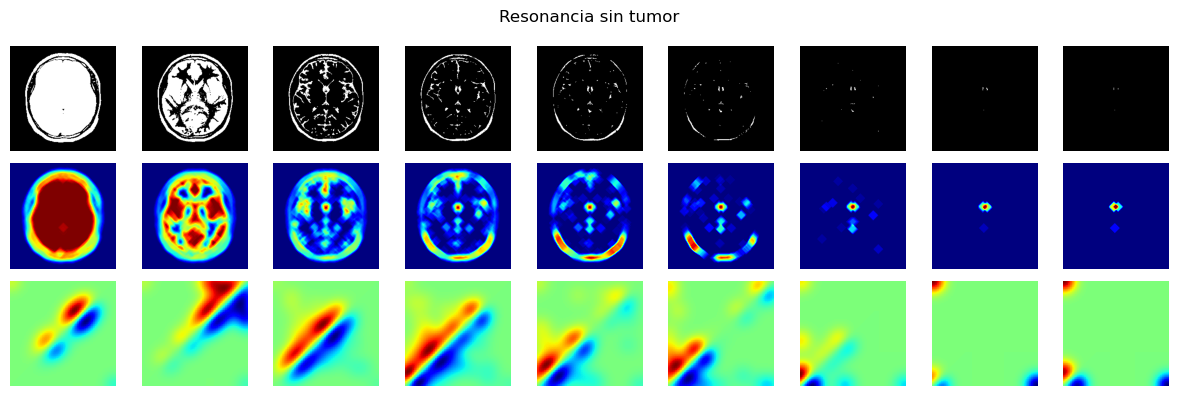

In [29]:
plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia sin tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_no_binarized = binarizer.fit_transform(im_no)
    im_no_binarized_plot = binarizer.plot(im_no_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_no_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_no_density = density_filtration.fit_transform(im_no_binarized)
    im_no_density_plot = density_filtration.plot(im_no_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_no_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_no_cubical = cubical_persistence.fit_transform(im_no_density)
    im_no_cubical_scaled = scaler.fit_transform(im_no_cubical)
    im_no_cubical_heat = heat_kernel.fit_transform(im_no_cubical_scaled)
    im_no_cubical_heat_plot = heat_kernel.plot(im_no_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_no_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

## Diseño de un Pipeline

In [31]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn import set_config
from gtda.diagrams import PersistenceEntropy, Amplitude

thresholds = np.arange(0.1, 1, 0.1)
centers = product({37, 112 ,187}, {37, 112 ,187})

binarizers = ([Binarizer(threshold=threshold, n_jobs=-1) for threshold in thresholds])
radial_filtrations = ([RadialFiltration(center=np.asarray(center), n_jobs=-1) for center in centers])
density_filtrations = ([DensityFiltration(radius=1, metric='euclidean', n_jobs=-1), 
                        DensityFiltration(radius=10, metric='cityblock', n_jobs=-1)])

steps_original = [
    [
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1)
    ] for filtration in radial_filtrations 
]

steps_binarizer = [
    [
        binarizer,
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1)
    ] for filtration in density_filtrations
    for binarizer in binarizers
]

metric_iter = [
    {'metric':'bottleneck', 'metric_params':{}},
    {'metric':'wasserstein', 'metric_params':{'p':1}},
    {'metric':'wasserstein', 'metric_params':{'p':2}},
    {'metric':'landscape', 'metric_params':{'p':1, 'n_layers':1, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':1, 'n_layers':2, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':2, 'n_layers':1, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':2, 'n_layers':2, 'n_bins':100}},
    {'metric':'betti', 'metric_params':{'p':1, 'n_bins':100}},
    {'metric':'betti', 'metric_params':{'p':2, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':1, 'sigma':1.6, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':1, 'sigma':3.2, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':2, 'sigma':1.6, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':2, 'sigma':3.2, 'n_bins':100}}
]
amplitudes = ([Amplitude(**metric, n_jobs=-1) for metric in metric_iter])
amplitudes_union = make_union(*[PersistenceEntropy(nan_fill_value=-1)] + amplitudes)

pipe_original = make_union(
    *[make_pipeline(*step, amplitudes_union) for step in steps_original], n_jobs=-1
)

pipe_binarizer = make_union(
    *[make_pipeline(*step, amplitudes_union) for step in steps_binarizer], n_jobs=-1
)

tda_pipeline = make_union(pipe_original, pipe_binarizer)

set_config(display='diagram')
tda_pipeline

FeatureUnion(transformer_list=[('featureunion-1',
                                FeatureUnion(n_jobs=-1,
                                             transformer_list=[('pipeline-1',
                                                                Pipeline(steps=[('radialfiltration',
                                                                                 RadialFiltration(center=array([112, 112]),
                                                                                                  n_jobs=-1)),
                                                                                ('cubicalpersistence',
                                                                                 CubicalPersistence(n_jobs=-1)),
                                                                                ('scaler',
                                                                                 Scaler(n_jobs=-1)),
                                                                                ('featureunion',
                                                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                                                 Persis...
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 1,
                                                                                                                                          'sigma': 1.6},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-11',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 1,
                                                                                                                                          'sigma': 3.2},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-12',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 2,
                                                                                                                                          'sigma': 1.6},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-13',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,

In [32]:
%%time
im_yes_pipeline = tda_pipeline.fit_transform(im_yes)
im_yes_pipeline.shape

CPU times: total: 156 ms
Wall time: 20.5 s


(1, 756)